In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from FinanceToolkit import AssetManagement as am
import yfinance as yf

In [3]:
def gbm_multi(n_step=252, n_scenario=1000, mu=None, sigma=None, corr_matrix=None, p_0=100, allocation=None):
    """
    Evolution of correlated GBM portfolio via Monte Carlo, returning aggregate portfolio trajectories.
    
    :param n_step: number of time steps
    :param n_scenario: number of Monte Carlo scenarios
    :param mu: array of annualized expected returns (length n_asset)
    :param sigma: array of annualized volatilities (length n_asset)
    :param corr_matrix: correlation matrix (n_asset x n_asset)
    :param p_0: interger of initial portfolio value
    :param allocation: array of portfolio weights (length n_asset)
    :return: 2D numpy array of shape (n_steps, n_scenarios) — portfolio value or return
    """
    mu = np.array(mu)
    sigma = np.array(sigma)
    allocation = np.array(allocation)
    n_asset = len(mu)
    corr_matrix = np.array(corr_matrix)
    
    assert mu.shape[0] == sigma.shape[0] == allocation.shape[0] == corr_matrix.shape[0] == corr_matrix.shape[1], "Shape mismatch among inputs"
    assert np.isclose(np.sum(allocation), 1), "Allocation weights must sum to 1"
    assert p_0 > 0, "Initial portfolio must be positive"

    # Generate Cholesky decomposition of covariance matrix
    cov_matrix = np.outer(sigma, sigma) * corr_matrix
    chol_matrix = np.linalg.cholesky(cov_matrix)

    # Simulate correlated shocks
    Z = np.random.normal(size=(n_step, n_scenario, n_asset))
    correlated_Z = Z @ chol_matrix.T

    # Drift and diffusion
    dt = 1 / 252    # Assuming daily steps
    drift = (1 + mu) ** dt
    diffusion = np.sqrt(dt)

    # Calculate returns
    returns = np.empty((n_step, n_scenario, n_asset))
    returns[0] = 1
    for i in range(1, n_step):
        returns[i] = drift * np.exp(correlated_Z[i] * diffusion)

    # Calculate portfolio prices
    return (p_0 * allocation * np.cumprod(returns, axis=0)).sum(axis=2)

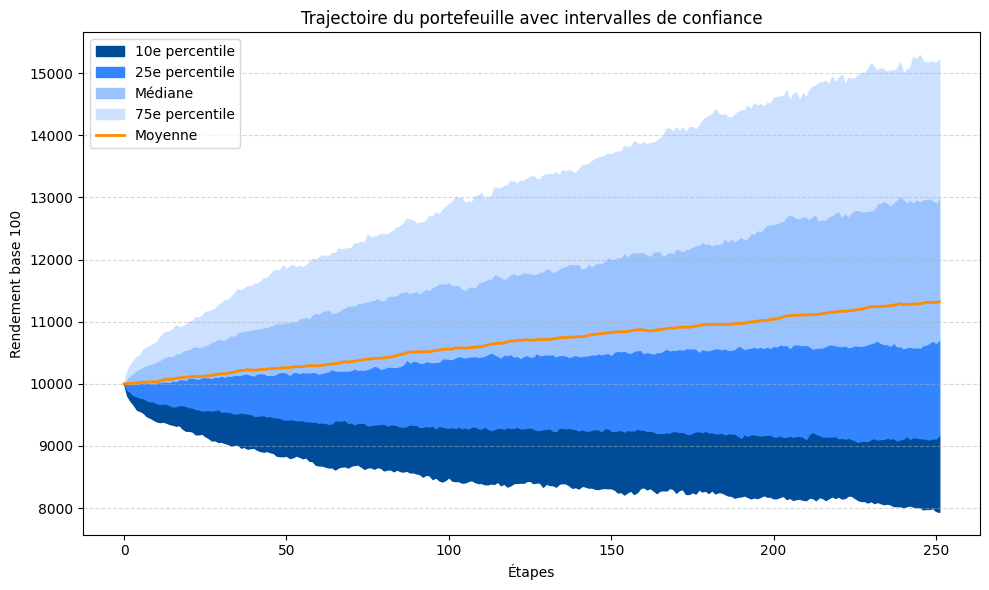

In [4]:
n_step = 252
n_scenario = 1000

mu = [0.05, 0.07, 0.06]
sigma = [0.15, 0.50, 0.18]
corr_matrix = [[1.0, 0.5, 0.3],
               [0.5, 1.0, 0.4],
               [0.3, 0.4, 1.0]]
p_0 = 10000
allocation = [0.4, 0.4, 0.2]

data = gbm_multi(
    n_step=n_step, 
    n_scenario=n_scenario, 
    mu=mu, 
    sigma=sigma, 
    corr_matrix=corr_matrix, 
    p_0=p_0, 
    allocation=allocation
)

# Calcul des percentiles
p10 = np.percentile(data, 10, axis=1)
p25 = np.percentile(data, 25, axis=1)
p50 = np.percentile(data, 50, axis=1)
p75 = np.percentile(data, 75, axis=1)
p90 = np.percentile(data, 90, axis=1)
mean = np.mean(data, axis=1)

# Tracer les intervalles
plt.figure(figsize=(10, 6))
plt.fill_between(range(n_step), p10, p25, color="#004c99", alpha=1, label="10e percentile")
plt.fill_between(range(n_step), p25, p50, color="#3385ff", alpha=1, label="25e percentile")
plt.fill_between(range(n_step), p50, p75, color="#99c2ff", alpha=1, label="Médiane")
plt.fill_between(range(n_step), p75, p90, color="#cce0ff", alpha=1, label="75e percentile")
plt.plot(range(n_step), mean, color="darkorange", linewidth=2, label="Moyenne")
plt.legend()
plt.title("Trajectoire du portefeuille avec intervalles de confiance")
plt.xlabel("Étapes")
plt.ylabel("Rendement base 100")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

interactive(children=(IntSlider(value=3, description='N assets', max=10, min=1), BoundedIntText(value=252, des…

Button(button_style='success', description='Run Simulation', style=ButtonStyle())

Output()

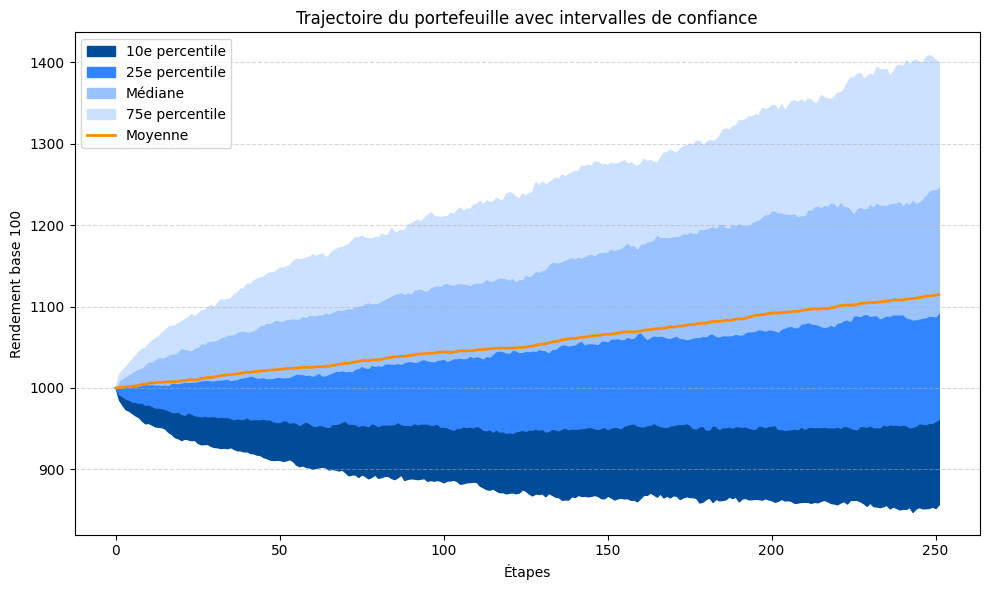

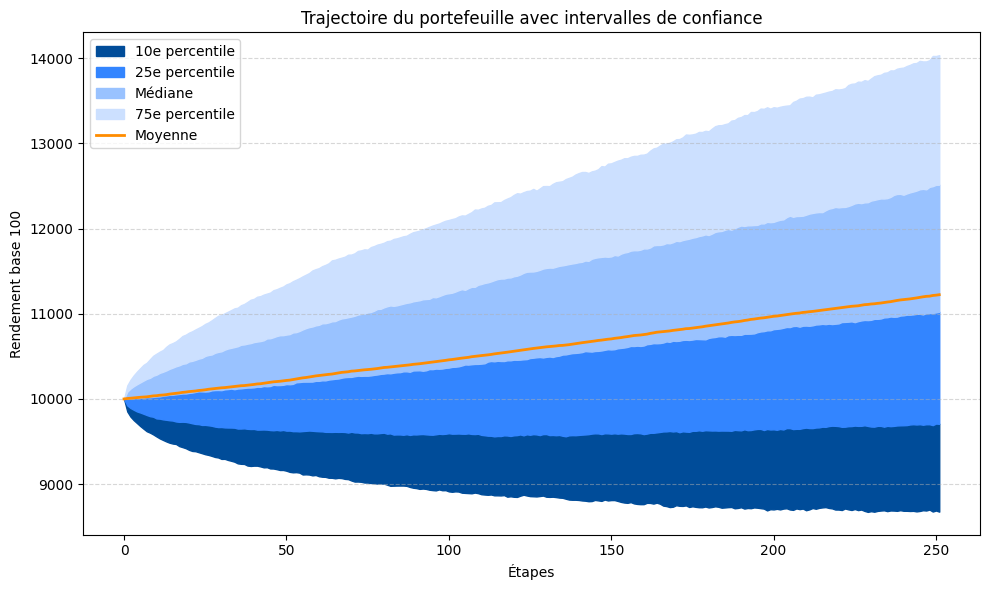

In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# BoundIntText pour la valeur initiale du portefeuille 
p_0 = widgets.BoundedIntText(value=1000, min=100, max=1000000, step=1, description='Value at t=0')
n_step = widgets.BoundedIntText(value=252, min=1, max=2520, step=1, description='N steps')
n_scenario = widgets.BoundedIntText(value=1000, min=1, max=10000, step=1, description='N scenario')

# IntSlider pour le nombre de titres
n_asset = widgets.IntSlider(value=3, min=1, max=10, step=1, description='N assets')

# Conteneur pour les inputs
asset_box = widgets.VBox()

# Liste persistante de widgets
asset_widgets_list = []

# Dictionnaire pour stocker proprement les données
ptf_dict = {}

def create_or_update_widgets(n_asset, n_step, n_scenario, p_0):
    current_len = len(asset_widgets_list)

    if n_asset > current_len:
        for i in range(current_len, n_asset):
            ticker_widget = widgets.Text(description=f'Asset {i+1}', placeholder='Ticker')
            weight_widget = widgets.BoundedFloatText(value=0.0, min=0, max=100, step=1, description='Allocation')
            asset_widgets_list.append(widgets.HBox([ticker_widget, weight_widget]))
    elif n_asset < current_len:
        del asset_widgets_list[n_asset:]

    # Mettre à jour les descriptions
    for idx, hbox in enumerate(asset_widgets_list[:n_asset]):
        hbox.children[0].description = f'Asset {idx+1}'
        hbox.children[1].description = 'Allocation'

    asset_box.children = asset_widgets_list[:n_asset]

# Synchronisation automatique
widgets.interact(create_or_update_widgets, n_step=n_step, n_scenario=n_scenario, p_0=p_0, n_asset=n_asset)

# Bouton de validation
button = widgets.Button(description="Run Simulation", button_style='success')
output = widgets.Output()

def run_simulation(b):
    with output:
        clear_output()
        ptf_dict.clear()

        for line in asset_box.children:
            ticker = line.children[0].value.strip()
            allocation = line.children[1].value / 100
            if ticker: ptf_dict[ticker] = allocation

        if sum(ptf_dict.values()) != 1:
            print("Error: Allocations must sum to 100%")
            return
        else:
            print("Asset allocation:")
            for ticker, allocation in ptf_dict.items():
                print(f"{ticker} : {allocation:.2%}")
    
    history = pd.DataFrame()
    for ticker in ptf_dict.keys():
        data = yf.Ticker(ticker).history('10y')['Close']
        data.name = ticker
        history = pd.concat([history, data], axis=1)
    history.index = pd.to_datetime(history.index)
    history = history.resample('B').last().ffill()
    history.index = history.index.tz_localize(None)
    history = history.dropna()
    mu = am.theta(history)
    sigma = am.sigma(history)
    corr_matrix = history.pct_change(fill_method=None).corr().values

    simulation_results = gbm_multi(
        n_step=n_step.value, 
        n_scenario=n_scenario.value, 
        mu=mu, 
        sigma=sigma, 
        corr_matrix=corr_matrix, 
        p_0=p_0.value, 
        allocation=list(ptf_dict.values())
    )
    
    # Calcul des percentiles
    p10 = np.percentile(simulation_results, 10, axis=1)
    p25 = np.percentile(simulation_results, 25, axis=1)
    p50 = np.percentile(simulation_results, 50, axis=1)
    p75 = np.percentile(simulation_results, 75, axis=1)
    p90 = np.percentile(simulation_results, 90, axis=1)
    mean = np.mean(simulation_results, axis=1)

    # Tracer les intervalles
    plt.figure(figsize=(10, 6))
    plt.fill_between(range(n_step.value), p10, p25, color="#004c99", alpha=1, label="10e percentile")
    plt.fill_between(range(n_step.value), p25, p50, color="#3385ff", alpha=1, label="25e percentile")
    plt.fill_between(range(n_step.value), p50, p75, color="#99c2ff", alpha=1, label="Médiane")
    plt.fill_between(range(n_step.value), p75, p90, color="#cce0ff", alpha=1, label="75e percentile")
    plt.plot(range(n_step.value), mean, color="darkorange", linewidth=2, label="Moyenne")
    plt.legend()
    plt.title("Trajectoire du portefeuille avec intervalles de confiance")
    plt.xlabel("Étapes")
    plt.ylabel("Rendement base 100")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

button.on_click(run_simulation)

# Affichage complet
display(asset_box, button, output)


In [14]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Widgets pour les paramètres initiaux
p_0 = widgets.BoundedIntText(value=1000, min=100, max=1000000, step=1, description='Portfolio at t=0')
n_step = widgets.BoundedIntText(value=252, min=1, max=2520, step=1, description='N steps')
n_scenario = widgets.BoundedIntText(value=1000, min=1, max=10000, step=1, description='N scenario')
n_asset = widgets.IntSlider(value=3, min=1, max=10, step=1, description='N assets')

# Conteneur pour les inputs des actifs
asset_box = widgets.VBox()
asset_widgets_list = []
ptf_dict = {}

def create_or_update_widgets(n_asset, n_step, n_scenario, p_0):
    current_len = len(asset_widgets_list)
    if n_asset > current_len:
        for i in range(current_len, n_asset):
            ticker_widget = widgets.Text(description=f'Asset {i+1}', placeholder='Ticker')
            weight_widget = widgets.BoundedFloatText(value=0.0, min=0, max=100, step=1, description='Allocation')
            asset_widgets_list.append(widgets.HBox([ticker_widget, weight_widget]))
    elif n_asset < current_len:
        del asset_widgets_list[n_asset:]

    for idx, hbox in enumerate(asset_widgets_list[:n_asset]):
        hbox.children[0].description = f'Asset {idx+1}'
        hbox.children[1].description = 'Allocation'
    asset_box.children = asset_widgets_list[:n_asset]

widgets.interact(create_or_update_widgets, n_step=n_step, n_scenario=n_scenario, p_0=p_0, n_asset=n_asset)

# Bouton de validation et zone de sortie pour le graphique
button = widgets.Button(description="Run Simulation", button_style='success')
output = widgets.Output()

def run_simulation(b):
    with output:
        clear_output()
        ptf_dict.clear()
        for line in asset_box.children:
            ticker = line.children[0].value.strip()
            allocation = line.children[1].value / 100
            if ticker:
                ptf_dict[ticker] = allocation

        if not ptf_dict or sum(ptf_dict.values()) != 1:
            print("Error: Allocations must sum to 100%")
            return

        print("Asset allocation:")
        for ticker, allocation in ptf_dict.items():
            print(f"{ticker} : {allocation:.2%}")

        history = pd.DataFrame()
        for ticker in ptf_dict.keys():
            data = yf.Ticker(ticker).history('10y')['Close']
            data.name = ticker
            history = pd.concat([history, data], axis=1)

        history.index = pd.to_datetime(history.index)
        history = history.resample('B').last().ffill()
        history.index = history.index.tz_localize(None)
        history = history.dropna()

        mu = np.log(history / history.shift(1)).mean().values * 252
        sigma = np.log(history / history.shift(1)).std().values * np.sqrt(252)
        corr_matrix = history.pct_change(fill_method=None).corr().values

        simulation_results = gbm_multi(
            n_step=n_step.value,
            n_scenario=n_scenario.value,
            mu=mu,
            sigma=sigma,
            corr_matrix=corr_matrix,
            p_0=p_0.value,
            allocation=list(ptf_dict.values())
        )

        # Calcul des percentiles
        p10 = np.percentile(simulation_results, 10, axis=1)
        p25 = np.percentile(simulation_results, 25, axis=1)
        p50 = np.percentile(simulation_results, 50, axis=1)
        p75 = np.percentile(simulation_results, 75, axis=1)
        p90 = np.percentile(simulation_results, 90, axis=1)
        mean = np.mean(simulation_results, axis=1)

        # Tracer les intervalles
        plt.figure(figsize=(10, 6))
        plt.fill_between(range(n_step.value), p10, p25, color="#004c99", alpha=1, label="10e percentile")
        plt.fill_between(range(n_step.value), p25, p50, color="#3385ff", alpha=1, label="25e percentile")
        plt.fill_between(range(n_step.value), p50, p75, color="#99c2ff", alpha=1, label="Médiane")
        plt.fill_between(range(n_step.value), p75, p90, color="#cce0ff", alpha=1, label="75e percentile")
        plt.plot(range(n_step.value), mean, color="darkorange", linewidth=2, label="Moyenne")
        plt.legend()
        plt.title("Trajectoire du portefeuille avec intervalles de confiance")
        plt.xlabel("Étapes")
        plt.ylabel("Rendement base 100")
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

button.on_click(run_simulation)

# Affichage complet
display(asset_box, button, output)

interactive(children=(IntSlider(value=3, description='N assets', max=10, min=1), BoundedIntText(value=252, des…

Button(button_style='success', description='Run Simulation', style=ButtonStyle())

Output()

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

def gbm_multi(n_step=252, n_scenario=1000, mu=None, sigma=None, corr_matrix=None, p_0=100, allocation=None):
    """
    Evolution of correlated GBM portfolio via Monte Carlo, returning aggregate portfolio trajectories.
    
    :param n_step: number of time steps
    :param n_scenario: number of Monte Carlo scenarios
    :param mu: array of annualized expected returns (length n_asset)
    :param sigma: array of annualized volatilities (length n_asset)
    :param corr_matrix: correlation matrix (n_asset x n_asset)
    :param p_0: interger of initial portfolio value
    :param allocation: array of portfolio weights (length n_asset)
    :return: 2D numpy array of shape (n_steps, n_scenarios) — portfolio value or return
    """
    mu = np.array(mu)
    sigma = np.array(sigma)
    allocation = np.array(allocation)
    n_asset = len(mu)
    corr_matrix = np.array(corr_matrix)
    
    assert mu.shape[0] == sigma.shape[0] == allocation.shape[0] == corr_matrix.shape[0] == corr_matrix.shape[1], "Shape mismatch among inputs"
    assert np.isclose(np.sum(allocation), 1), "Allocation weights must sum to 1"
    assert p_0 > 0, "Initial portfolio must be positive"

    # Generate Cholesky decomposition of covariance matrix
    cov_matrix = np.outer(sigma, sigma) * corr_matrix
    chol_matrix = np.linalg.cholesky(cov_matrix)

    # Simulate correlated shocks
    Z = np.random.normal(size=(n_step, n_scenario, n_asset))
    correlated_Z = Z @ chol_matrix.T

    # Drift and diffusion
    dt = 1 / 252    # Assuming daily steps
    drift = (1 + mu) ** dt
    diffusion = np.sqrt(dt)

    # Calculate returns
    returns = np.empty((n_step, n_scenario, n_asset))
    returns[0] = 1
    for i in range(1, n_step):
        returns[i] = drift * np.exp(correlated_Z[i] * diffusion)

    # Calculate portfolio prices
    return (p_0 * allocation * np.cumprod(returns, axis=0)).sum(axis=2)

# Widgets pour les paramètres de simulation
simulation_params_box = widgets.VBox([
    widgets.BoundedIntText(value=1000, min=100, max=1000000, step=1, description='Value at t=0'),
    widgets.BoundedIntText(value=252, min=1, max=2520, step=1, description='N steps'),
    widgets.BoundedIntText(value=1000, min=1, max=10000, step=1, description='N scenario')
])

# Widget pour le nombre d'actifs
n_asset = widgets.IntSlider(value=3, min=1, max=10, step=1, description='N assets')

# Conteneur pour les inputs des actifs
asset_box = widgets.VBox()
asset_widgets_list = []
ptf_dict = {}

def create_or_update_widgets(n_asset):
    current_len = len(asset_widgets_list)
    if n_asset > current_len:
        for i in range(current_len, n_asset):
            ticker_widget = widgets.Text(description=f'Asset {i+1}', placeholder='Ticker')
            weight_widget = widgets.BoundedFloatText(value=0.0, min=0, max=100, step=1, description='Allocation')
            asset_widgets_list.append(widgets.HBox([ticker_widget, weight_widget]))
    elif n_asset < current_len:
        del asset_widgets_list[n_asset:]

    for idx, hbox in enumerate(asset_widgets_list[:n_asset]):
        hbox.children[0].description = f'Asset {idx+1}'
        hbox.children[1].description = 'Allocation'
    asset_box.children = asset_widgets_list[:n_asset]

# Utiliser `widgets.interactive` pour éviter l'affichage automatique
widget = widgets.interactive(create_or_update_widgets, n_asset=n_asset)

# Bouton de validation et zone de sortie pour le graphique
button = widgets.Button(description="Run Simulation", button_style='success')
output = widgets.Output()

def run_simulation(b):
    with output:
        clear_output()
        ptf_dict.clear()
        for line in asset_box.children:
            ticker = line.children[0].value.strip()
            allocation = line.children[1].value / 100
            if ticker:
                ptf_dict[ticker] = allocation

        if not ptf_dict or not np.isclose(sum(ptf_dict.values()), 1):
            print("Error: Allocations must sum to 100%")
            return

        print("Asset allocation:")
        for ticker, allocation in ptf_dict.items():
            print(f"{ticker} : {allocation:.2%}")

        history = pd.DataFrame()
        for ticker in ptf_dict.keys():
            data = yf.Ticker(ticker).history('10y')['Close']
            data.name = ticker
            history = pd.concat([history, data], axis=1)

        history.index = pd.to_datetime(history.index)
        history = history.resample('B').last().ffill()
        history.index = history.index.tz_localize(None)
        history = history.dropna()

        mu = np.log(history / history.shift(1)).mean().values * 252
        sigma = np.log(history / history.shift(1)).std().values * np.sqrt(252)
        corr_matrix = history.pct_change(fill_method=None).corr()

        print(f"\nAsset parameters:\n{pd.DataFrame([mu, sigma], index=['Mu', 'Sigma'], columns=ptf_dict.keys()).T.round(2)}")
        print(f"\nCorrelation matrix:\n{corr_matrix.round(2)}")

        simulation_results = gbm_multi(
            n_step=simulation_params_box.children[1].value,
            n_scenario=simulation_params_box.children[2].value,
            mu=mu,
            sigma=sigma,
            corr_matrix=corr_matrix.values,
            p_0=simulation_params_box.children[0].value,
            allocation=list(ptf_dict.values())
        )

        # Calcul des percentiles
        p10 = np.percentile(simulation_results, 10, axis=1)
        p25 = np.percentile(simulation_results, 25, axis=1)
        p50 = np.percentile(simulation_results, 50, axis=1)
        p75 = np.percentile(simulation_results, 75, axis=1)
        p90 = np.percentile(simulation_results, 90, axis=1)
        mean = np.mean(simulation_results, axis=1)

        # Tracer les intervalles
        plt.figure(figsize=(10, 6))
        plt.fill_between(range(simulation_params_box.children[1].value), p10, p25, color="#004c99", alpha=1, label="10e percentile")
        plt.fill_between(range(simulation_params_box.children[1].value), p25, p50, color="#3385ff", alpha=1, label="25e percentile")
        plt.fill_between(range(simulation_params_box.children[1].value), p50, p75, color="#99c2ff", alpha=1, label="Médiane")
        plt.fill_between(range(simulation_params_box.children[1].value), p75, p90, color="#cce0ff", alpha=1, label="75e percentile")
        plt.plot(range(simulation_params_box.children[1].value), mean, color="darkorange", linewidth=2, label="Moyenne")
        plt.legend()
        plt.title("Trajectoire du portefeuille avec intervalles de confiance")
        plt.xlabel("Étapes")
        plt.ylabel("Rendement base 100")
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

button.on_click(run_simulation)

# Affichage complet
display(
    widgets.VBox([widgets.Label("Paramètres de Simulation"), simulation_params_box]),
    widgets.VBox([widgets.Label("Assets"), n_asset, asset_box]),
    button,
    output
)


Button(button_style='success', description='Run Simulation', style=ButtonStyle())

Output()

In [ ]:
# Import des bibliothèques nécessaires
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

def gbm_multi(n_step=252, n_scenario=1000, mu=None, sigma=None, corr_matrix=None, p_0=100, allocation=None):
    """
    Simuler un portefeuille multi-actifs via un processus de type GBM corrélé (Monte Carlo).

    :param n_step: nombre de pas de temps (par défaut 252 jours ouvrés)
    :param n_scenario: nombre de scénarios de Monte Carlo
    :param mu: array des rendements annuels attendus
    :param sigma: array des volatilités annuelles
    :param corr_matrix: matrice de corrélation entre les actifs
    :param p_0: valeur initiale du portefeuille
    :param allocation: poids alloués à chaque actif dans le portefeuille
    :return: matrice (n_step x n_scenario) représentant la valeur du portefeuille dans le temps
    """
    mu = np.array(mu)
    sigma = np.array(sigma)
    allocation = np.array(allocation)
    corr_matrix = np.array(corr_matrix)
    n_asset = len(mu)

    # Contrôles de cohérence
    assert mu.shape[0] == sigma.shape[0] == allocation.shape[0] == corr_matrix.shape[0] == corr_matrix.shape[1], "Shape mismatch among inputs"
    assert np.isclose(np.sum(allocation), 1), "Allocation weights must sum to 1"
    assert p_0 > 0, "Initial portfolio must be positive"

    # Construction de la matrice de covariance via la décomposition de Cholesky
    cov_matrix = np.outer(sigma, sigma) * corr_matrix
    chol_matrix = np.linalg.cholesky(cov_matrix)

    # Simulation de chocs normalisés corrélés
    Z = np.random.normal(size=(n_step, n_scenario, n_asset))
    correlated_Z = Z @ chol_matrix.T

    # Calcul du drift et de la diffusion
    dt = 1 / 252  # Pas de temps quotidien
    drift = (1 + mu) ** dt
    diffusion = np.sqrt(dt)

    # Simulation des rendements
    returns = np.empty((n_step, n_scenario, n_asset))
    returns[0] = 1
    for i in range(1, n_step):
        returns[i] = drift * np.exp(correlated_Z[i] * diffusion)

    # Agrégation des valeurs du portefeuille selon les allocations
    return (p_0 * allocation * np.cumprod(returns, axis=0)).sum(axis=2)

# Widgets de saisie des paramètres de simulation
simulation_params_box = widgets.VBox([
    widgets.BoundedIntText(value=1000, min=100, max=1000000, step=1, description='Value at t=0'),
    widgets.BoundedIntText(value=252, min=1, max=2520, step=1, description='N steps'),
    widgets.BoundedIntText(value=1000, min=1, max=10000, step=1, description='N scenario')
])

# Widget pour sélectionner le nombre d'actifs
n_asset = widgets.IntSlider(value=3, min=1, max=10, step=1, description='N assets')

# Conteneurs pour les champs d’entrée des actifs
asset_box = widgets.VBox()
asset_widgets_list = []
ptf_dict = {}

def create_or_update_widgets(n_asset):
    """
    Créer ou ajuster dynamiquement les widgets selon le nombre d'actifs sélectionnés.
    """
    current_len = len(asset_widgets_list)
    if n_asset > current_len:
        for i in range(current_len, n_asset):
            ticker_widget = widgets.Text(description=f'Asset {i+1}', placeholder='Ticker')
            weight_widget = widgets.BoundedFloatText(value=0.0, min=0, max=100, step=1, description='Allocation')
            asset_widgets_list.append(widgets.HBox([ticker_widget, weight_widget]))
    elif n_asset < current_len:
        del asset_widgets_list[n_asset:]

    for idx, hbox in enumerate(asset_widgets_list[:n_asset]):
        hbox.children[0].description = f'Asset {idx+1}'
        hbox.children[1].description = 'Allocation'
    asset_box.children = asset_widgets_list[:n_asset]

# Lier le slider de nombre d'actifs à la mise à jour des widgets
widget = widgets.interactive(create_or_update_widgets, n_asset=n_asset)

# Bouton de lancement de la simulation et zone d’affichage
button = widgets.Button(description="Run Simulation", button_style='success')
output = widgets.Output()

def run_simulation(b):
    """
    Exécuter la simulation : téléchargement des données, estimation des paramètres, simulation GBM, et affichage.
    """
    with output:
        clear_output()
        ptf_dict.clear()

        # Récupération des tickers et allocations
        for line in asset_box.children:
            ticker = line.children[0].value.strip()
            allocation = line.children[1].value / 100
            if ticker:
                ptf_dict[ticker] = allocation

        # Vérifier que les poids totalisent 100%
        if not ptf_dict or not np.isclose(sum(ptf_dict.values()), 1):
            print("Error: Allocations must sum to 100%")
            return

        print("Asset allocation:")
        for ticker, allocation in ptf_dict.items():
            print(f"{ticker} : {allocation:.2%}")

        # Téléchargement des prix sur 10 ans
        history = pd.DataFrame()
        for ticker in ptf_dict.keys():
            data = yf.Ticker(ticker).history('10y')['Close']
            data.name = ticker
            history = pd.concat([history, data], axis=1)

        # Prétraitement des données
        history.index = pd.to_datetime(history.index)
        history = history.resample('B').last().ffill()
        history.index = history.index.tz_localize(None)
        history = history.dropna()

        # Calcul des paramètres : rendement, volatilité, corrélation
        mu = np.log(history / history.shift(1)).mean().values * 252
        sigma = np.log(history / history.shift(1)).std().values * np.sqrt(252)
        corr_matrix = history.pct_change(fill_method=None).corr()

        print(f"\nAsset parameters:\n{pd.DataFrame([mu*100, sigma*100], index=['Mu', 'Sigma'], columns=ptf_dict.keys()).T.round(2)}")
        print(f"\nCorrelation matrix:\n{corr_matrix.round(2)}")

        # Lancer la simulation GBM
        simulation_results = gbm_multi(
            n_step=simulation_params_box.children[1].value,
            n_scenario=simulation_params_box.children[2].value,
            mu=mu,
            sigma=sigma,
            corr_matrix=corr_matrix.values,
            p_0=simulation_params_box.children[0].value,
            allocation=list(ptf_dict.values())
        )

        # Calcul des percentiles pour les bandes de confiance
        p10 = np.percentile(simulation_results, 10, axis=1)
        p25 = np.percentile(simulation_results, 25, axis=1)
        p50 = np.percentile(simulation_results, 50, axis=1)
        p75 = np.percentile(simulation_results, 75, axis=1)
        p90 = np.percentile(simulation_results, 90, axis=1)
        mean = np.mean(simulation_results, axis=1)

        # Affichage des résultats
        plt.figure(figsize=(10, 6))
        plt.fill_between(range(simulation_params_box.children[1].value), p10, p25, color="#004c99", alpha=1, label="10e percentile")
        plt.fill_between(range(simulation_params_box.children[1].value), p25, p50, color="#3385ff", alpha=1, label="25e percentile")
        plt.fill_between(range(simulation_params_box.children[1].value), p50, p75, color="#99c2ff", alpha=1, label="Médiane")
        plt.fill_between(range(simulation_params_box.children[1].value), p75, p90, color="#cce0ff", alpha=1, label="75e percentile")
        plt.plot(range(simulation_params_box.children[1].value), mean, color="darkorange", linewidth=2, label="Moyenne")
        plt.legend()
        plt.title("Trajectoire du portefeuille avec intervalles de confiance")
        plt.xlabel("Étapes")
        plt.ylabel("Rendement base 100")
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

# Lier le bouton à la fonction de simulation
button.on_click(run_simulation)

# Affichage de tous les éléments interactifs
display(
    widgets.VBox([widgets.Label("Simulation Parameters"), simulation_params_box]),
    widgets.VBox([widgets.Label("Assets Parameters"), n_asset, asset_box]),
    button,
    output
)


Button(button_style='success', description='Run Simulation', style=ButtonStyle())

Output()